# Jamie Clark
# CIS 600 Fundamentals of Data and Knowledge Mining
# HW3: NBC, KNN and Ensemble Learning

## Table of Contents
<ul>
<li><a href="#Exec_Summ">Exectuive Summary</a></li>
<li><a href="#Intro">Introduction</a></li>
<li><a href="#Data_Prep">Data Preparation</a></li>
<li><a href="#NB">Naive Bayes Classifier</a></li>
    <li><a href="#KNN">K Nearest Neighbors</a></li>
<li><a href="#GBM">Gradient Boosting Machine</a></li>
    <li><a href="#Predict">Predictions</a></li>
    <li><a href="#Conclusion">Conclusion</a></li>
</ul>

<a id='Exec_Summ'></a>
## Executive Summary 

In this homework assignment, I am going to use multiple machine learning algorithms, including naive
Bayes classifier, K Nearest Neighbor, Random Forest and Gradient Boosting Classifier to build a disease
diagnosis model. It is a binary classification problem to predict whether or not a patient has a certain
unspecified disease.

<a id='Intro'></a>
## Introduction 

I was given a dataset where we will look to determine whether or not a patient has a certain unspecified disease through multiple learning algorithms. In this report, we will prepare the data for each learning algorithm, build, tune and evaluate each different algorithm and end with predicting the results on a second dataset of patients.

Let's begin the report by running the different tools that we will need in order to complete the analysis and loading the datasets. We will use pandas and numpy for the bulk of our data analysis tools. We will use sklearn and its functions for machine learning algorithms. Matplotlib and Seaborn will be used to generate any graphs that are necessary for visualizations. We will establish our random seed at 66 so that results can be replicated throughout the report for verification. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn import tree #should help visualize tree
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
%matplotlib inline
np.random.seed(66)

In [2]:
train = pd.read_csv('Disease Prediction Training.csv')
test = pd.read_csv('Disease Prediction Testing.csv')

<a id='Data_Prep'></a>
## Data Preperation 

My initial review of the data showed that we have no null values to take care of, which is great for our learning algorithms. However, there are some outlier data points that need to be addressed in the High and Low Blood Pressure columns. We will first take care of those and then move on towards getting all of the data into numerical values.

For ease of our code, we will first remove the spaces in the High and Low Blood Pressure titles. 

In [3]:
train.rename(columns={'High Blood Pressure':'HighBloodPressure',
                    'Low Blood Pressure':'LowBloodPressure'},
           inplace=True)

Now let's look at the graph so we can get an understanding of where we'll need to adjust these values.

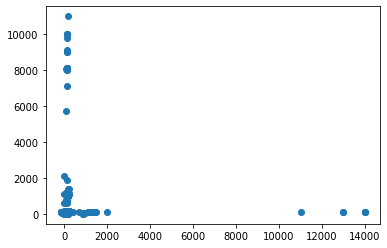

In [4]:
#train.plt.scatter(x='HighBloodPressure', y='LowBloodPressure')
plt.scatter(train.HighBloodPressure, train.LowBloodPressure);

Looking at this graph, many values are way outside of livable blood pressure values. We will remove any values that are above 250 for both High and Low blood pressure. In total, this will remove 27 High Blood Pressure rows and 659 Low Blood Pressure rows, roughly 1% of our data. 

In [5]:
train = train[train.HighBloodPressure <= 250]
train = train[train.LowBloodPressure <= 250]

Let's verify that everything looks good with our graph now.

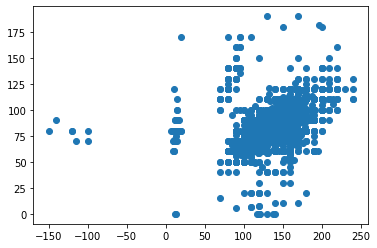

In [6]:
plt.scatter(train.HighBloodPressure, train.LowBloodPressure);

We have fixed our too high values, but now values that are too low have appeared for High Blood Pressure. Searching for these values we find that there are approximately 146 of them, which we will also now delete. 

In [7]:
train = train[train.HighBloodPressure >= 75]

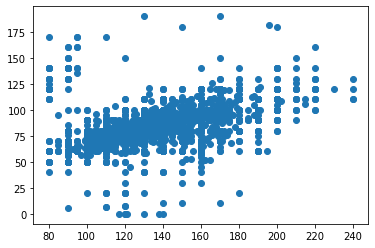

In [8]:
plt.scatter(train.HighBloodPressure, train.LowBloodPressure);

Now that our numbers look good, let's address our categorical data. We will be changing 'Female' to 0 and 'Male' to 1. We will also be changing 'Normal' to 0, 'High' to 1 and 'Too High' to 2.

In [9]:
#female set to 0 and male set to 1
train = train.replace('female',0)
train = train.replace('male', 1)
#normal 0, high 1, too high 2
train = train.replace('normal',0)
train = train.replace('too high',2)
train = train.replace('high',1)

In [10]:
train.describe()

,Age,Gender,Height,Weight,HighBloodPressure,LowBloodPressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
count,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000
mean,52.845354,0.348759,164.370163,74.108687,126.656619,81.351665,0.365076,0.225938,0.088129,0.054061,0.802981,0.495495
std,6.763391,0.476582,8.196676,14.262047,16.732572,9.852969,0.678819,0.571939,0.283485,0.226140,0.397751,0.499985
min,29.000000,0.000000,55.000000,11.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,1.000000,207.000000,200.000000,240.000000,190.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


Now that we have a clean dataset, lets create some subsets of this dataset that we can use for training and testing. First we will create a copy of our Train dataset, which will drop the 'Disease' column. We will create another dataframe that will hold the values of the 'Disease' column. Next we will split the data with 70% training and 30% testing. That will have prepared us to enter our algorithm building phase. 

In [11]:
X = train.copy()
X = X.drop(columns=['Disease'])
y = train.Disease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

<a id='NB'></a>
## Naive Bayes Classifier

We will start our algorithm create with the Naive Bayes Classifier. Since there are not hyperparameters that can be tuned, we will not be looking to optimize our accuracy of results. Instead we show this section as an example of how the Naive Bayes Classifier works in practice. 

We will run the algorithms in this order GuassianNB, BernoulliNB, MultinominalNB and GuassianNB with priors. The priors were calculated to be 49.5% 1s and the remainder 0s. At the end we will summarize the accuracies produced by all of these results. The algorithm with the highest accuracy will be used to predict the unknown dataset. 

Each algorithm will run with four lines of code that does the following:
1. Run the algorithm
2. Fit the algorithm to the data
3. Predict the values form the test set
4. Set a variable to hold the accuracy for later usage

In [12]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_pred = gnb.predict(X_test)
gnb_acc = round(metrics.accuracy_score(y_test, gnb_pred)*100, 2)

bnb = BernoulliNB()
bnb.fit(X_train,y_train)
bnb_pred = bnb.predict(X_test)
bnb_acc = round(metrics.accuracy_score(y_test, bnb_pred)*100, 2)

mnb = MultinomialNB()
mnb.fit(X_train,y_train)
mnb_pred = mnb.predict(X_test)
mnb_acc = round(metrics.accuracy_score(y_test, mnb_pred)*100, 2)

gnbp = GaussianNB(priors=[.49,.51])
gnbp.fit(X_train,y_train)
gnbp_pred = gnbp.predict(X_test)
gnbp_acc = round(metrics.accuracy_score(y_test, gnbp_pred)*100, 2)

| Method | Accuracy | Priors | 
| --- | --- | --- |
| Guassian | {{gnb_acc}}% | None |
| Bernoulli | {{bnb_acc}}% | None |
| Multinomial | {{mnb_acc}}% | None |
| Guassian w/ Priors | {{gnbp_acc}}% | .49/.51 |

There are a lot of similarities between the methods, but what surprised me was that the Bernoulli method was significantly lower than the others. I was also surprised that the priors seemed to have no effect on the accuracy, but that is probably because the priors are based on the data results and not previously found results.  

In the end it looks like Guassian will be the one to be in the final csv for predicting results. 

<a id='KNN'></a>
## K Nearest Neighbors

Now we're going to move to the K Nearest Neighbors algorithm. We will first show the algorithm with the default sklearn settings. Once we have those values, we will search to find the best hyperparameters that we should use and plot the accuracies. We will use the best of each hyperparameter to find the accuracy and move that value to the prediction of the results. The one hyperparameter that will remain constant, for efficiency, is n_jobs at -1 so that all of my CPU cores are utilized. 

In [13]:
neigh = KNeighborsClassifier(n_jobs=-1)
neigh.fit(X_train,y_train)
neigh_pred = neigh.predict(X_test)
neigh_default_acc = round(metrics.accuracy_score(y_test, neigh_pred)*100, 2)

The default accuracy produced {{neigh_default_acc}}%, which is a lot lower than what we received for the Nayes Bayes Classifier. Let's tune the hyperparameters and see if we can increase this accuracy. 

We will take each of the one hyper parameters and perform the KNeighborsClassifier function from 1 through 251. These will be placed into a dataframe and used to plot later on. 

In [14]:
#value to ensure all counters are the same length for each algorithm
length = 100

#Generating a count that we can use to adjust the ranges 
counter = pd.array(range(1,length))
#creating a dataframe to hold the results
df = pd.DataFrame({'Counts': counter })

#array to hold the values to put into the dataframe
tableCheck = []

#leaf size
# print("leaf_size")
for i in counter:
    clf2 = KNeighborsClassifier(leaf_size=i, n_jobs=-1)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
#     print(i)
    
df['leaf_size'] = tableCheck
tableCheck.clear()

#n_neighbords
# print("n_neighbors")
for i in counter:
    clf2 = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
#     print(i)
    
df['n_neighbors'] = tableCheck
tableCheck.clear()

Now that we've added all the accuracies, let's add them to a graph so that we can visually represent them.

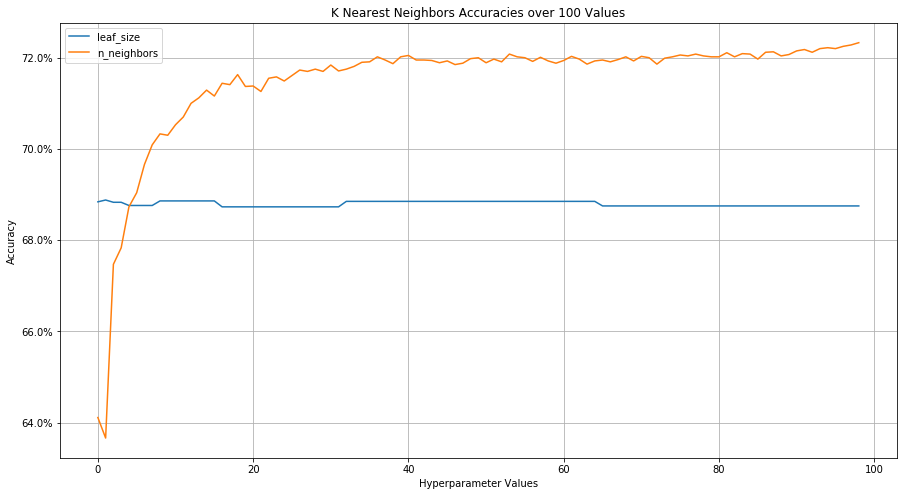

In [15]:
df = df.drop(columns='Counts')
g = df.plot.line(figsize=(15,8),title="K Nearest Neighbors Accuracies over 100 Values", grid=True);
g.set_xlabel("Hyperparameter Values")
g.set_ylabel("Accuracy")
g.yaxis.set_major_formatter(mtick.PercentFormatter())

The graph shows some interesting trends in the accuracies, but we're really interested in optimizing the entire algorithm. Let's choose the top five values in each hyperparameter and use those in a GridSearchCV in hopes that we can find a combination of the best that will create the best tuned algorithm for our purposes. As a printed check, we'll see what each hyperparameter value came out to be and our expected accuracy with these results. 

In [16]:
maxLeafSize = df['leaf_size'].nlargest(5).index.values.tolist()
maxNeighbors = df['n_neighbors'].nlargest(5).index.values.tolist()
#since the index are 0 based, we need to add 1 to get the proper values used
maxLeafSize = np.array(maxLeafSize) + 1
maxNeighbors = np.array(maxNeighbors) + 1

#we change the dict to match the parameters we are looking for in the estimator that is used
param_grid = {'leaf_size': maxLeafSize,
  'n_neighbors': maxNeighbors,}
grid = GridSearchCV(neigh, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Accuracy: {round(grid.best_score_*100, 2)}%")
for key, value in grid.best_params_.items():
  print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 72.27%
Hyperparameter: leaf_size; Value: 9
Hyperparameter: n_neighbors; Value: 99


Now we're going to add these values to an array that we can use to access them throughout the rest of the report. This will prevent us from hard coding values that may change if we change the sample test size. 

In [17]:
best_neigh = []
for key, value in grid.best_params_.items():
    best_neigh.append(value)

Now the final step to actually rerun the algorithm with the tuned hyperparameters. 

In [18]:
neigh_tuned = KNeighborsClassifier(n_jobs=-1, leaf_size=best_neigh[0], n_neighbors=best_neigh[1])
neigh_tuned.fit(X_train,y_train)
neigh_tuned_pred = neigh_tuned.predict(X_test)
neigh_tuned_acc = round(metrics.accuracy_score(y_test, neigh_tuned_pred)*100, 2)

So we did get a slight improvement on accuracy up to {{neigh_tuned_acc}}%. We will be using these hyperparameters and this setting for our predictions. 

<a id='RF'></a>
## Random Forest

The next algorithm that we're going to go to is the Random Forest. We will replicate what we did for the K Nearest Neighbors and start with the default Random Forest function, find the best hyperparameters and then compare the increase of the accuracy. 

In [19]:
rfor = RandomForestClassifier(n_jobs=-1)
rfor.fit(X_train,y_train)
rfor_pred = rfor.predict(X_test)
rfor_default_acc = round(metrics.accuracy_score(y_test, rfor_pred)*100, 2)

The default accuracy shown here is {{rfor_default_acc}}%. Let's see how much we can improve that by tuning our hyperparameters. We will use a similar process as the K Nearest Neighbors by finding the best numbers for each hyperparameter and combining them.  

In [39]:
#n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes
#Generating a count that we can use to adjust the ranges 
counter = pd.array(range(1,length))
#creating a dataframe to hold the results
df = pd.DataFrame({'Counts': counter })

#array to hold the values to put into the dataframe
tableCheck = []

#max depth
# print("max_depth")
for i in counter:
    clf2 = RandomForestClassifier(max_depth=i, n_jobs=-1)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
#     #debug code
#     if i % 10 == 0: 
#         print(i)

df['Max_Depth'] = tableCheck
tableCheck.clear()

#max_leaf_nodes
# print("max_leaf_nodes")
for i in counter:
    if i > 1:
        clf2 = RandomForestClassifier(max_leaf_nodes=i, n_jobs=-1)
        clf2.fit(X_train, y_train)
        y_pred = clf2.predict(X_test)
        y_pred = np.where(y_pred==True, 1, 0)
        tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    else:
        tableCheck.append(np.NaN)
#     #debug code
#     if i % 10 == 0:
#         print(i)
        
df['max_leaf_nodes'] = tableCheck
tableCheck.clear()

#min_samples_leaf
# print("min_samples_leaf")
for i in counter:
    clf2 = RandomForestClassifier(min_samples_leaf=i, n_jobs=-1)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    #debug code
#     if i % 10 == 0:
#         print(i)
        
df['min_samples_leaf'] = tableCheck
tableCheck.clear()

#min_samples_split
# print("min_samples_split")
for i in counter:
    if i > 1:
        clf2 = RandomForestClassifier(min_samples_split=i, n_jobs=-1)
        clf2.fit(X_train, y_train)
        y_pred = clf2.predict(X_test)
        y_pred = np.where(y_pred==True, 1, 0)
        tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    else:
        tableCheck.append(np.NaN)
    #debug code
#     if i % 10 == 0:
#         print(i)
        
df['min_samples_split'] = tableCheck
tableCheck.clear()

#min_samples_leaf
# print("n_estimators")
for i in counter:
    clf2 = RandomForestClassifier(n_estimators=i, n_jobs=-1)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    #debug code
#     if i % 10 == 0:
#         print(i)
        
df['n_estimators'] = tableCheck
tableCheck.clear()

Just to understand how these accuracies vary, let's take a look at the graph. 

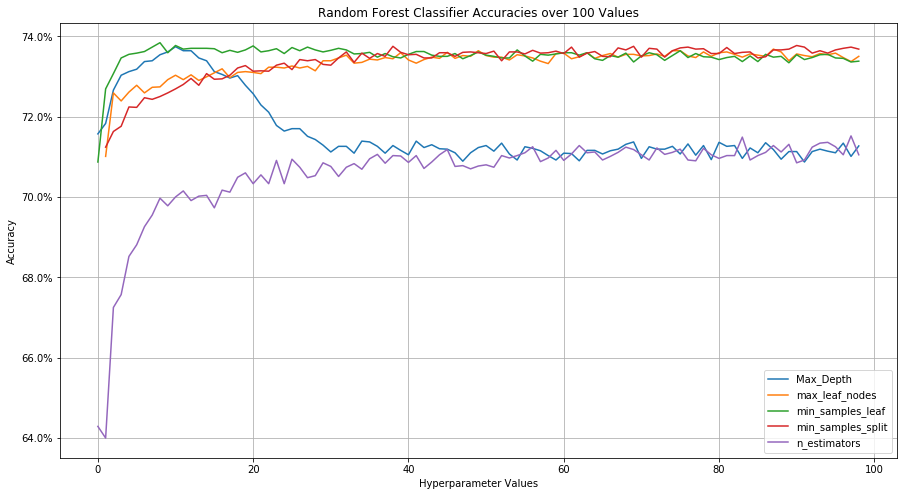

In [40]:
df = df.drop(columns='Counts')
g = df.plot.line(figsize=(15,8),title="Random Forest Classifier Accuracies over 100 Values", grid=True);
g.set_xlabel("Hyperparameter Values")
g.set_ylabel("Accuracy")
g.yaxis.set_major_formatter(mtick.PercentFormatter())

It's nice to see visually what this information looks like, but we really need the numbers programmatically for them to work well. Let's find the five largest values of accuracy for each hyperparameter and compare these together with the GridSearchCV function in order to find the best hyperparameters to use. At the bottom, we will print out the selection of hyperparameters, just for visual refernce of the report. 

In [22]:
maxDepth = df['Max_Depth'].nlargest(5).index.values.tolist()
maxLeafNodes = df['max_leaf_nodes'].nlargest(5).index.values.tolist()
minSamplesLeaf = df['min_samples_leaf'].nlargest(5).index.values.tolist()
minSamplesSplit = df['min_samples_split'].nlargest(5).index.values.tolist()
n_estimators = df['n_estimators'].nlargest(5).index.values.tolist()

#since the index are 0 based, we need to add 1 to get the proper values used
maxDepth = np.array(maxDepth) + 1
maxLeafNodes = np.array(maxLeafNodes) + 1
minSamplesLeaf = np.array(minSamplesLeaf) + 1
minSamplesSplit = np.array(minSamplesSplit) + 1
n_estimators = np.array(n_estimators) + 1

param_grid = {'criterion': ['gini', 'entropy'],
  'min_samples_split': minSamplesSplit,
  'max_depth': maxDepth,
  'min_samples_leaf': minSamplesLeaf,
  'max_leaf_nodes': maxLeafNodes,
  'n_estimators': n_estimators}
grid = GridSearchCV(rfor, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)


print(f"Accuracy: {round(grid.best_score_*100, 2)}%")
for key, value in grid.best_params_.items():
  print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 73.64%
Hyperparameter: criterion; Value: gini
Hyperparameter: max_depth; Value: 13
Hyperparameter: max_leaf_nodes; Value: 86
Hyperparameter: min_samples_leaf; Value: 18
Hyperparameter: min_samples_split; Value: 94
Hyperparameter: n_estimators; Value: 97


Let's take these values and place them in an array so that we can continue to reference them throughout the rest of the report programmatically. 

In [23]:
best_rfor = []
for key, value in grid.best_params_.items():
    best_rfor.append(value)

Now that we have the best hyperparameters, let's run the Random Forest Classifier again. This will be the parameters used to predict our final results. 

In [24]:
rfor_tuned = RandomForestClassifier(n_jobs=-1, criterion=best_rfor[0], max_depth=best_rfor[1], max_leaf_nodes=best_rfor[2], 
                                    min_samples_leaf=best_rfor[3], min_samples_split=best_rfor[4], n_estimators=best_rfor[5])
rfor_tuned.fit(X_train,y_train)
rfor_tuned_pred = rfor_tuned.predict(X_test)
rfor_tuned_acc = round(metrics.accuracy_score(y_test, rfor_tuned_pred)*100, 2)

We did improve upon our accuracy by increasing it to {{rfor_tuned_acc}}%. This is what we will be using to predict the final results.

<a id='GBM'></a>
## Gradient Boosting Machine

We will once again follow the same process. Take the default function parameters and then find the best options to tune the hyperparameters. Below is the default function. One default we've modified is warm_start to True rather than False. This helped with the GridSearchCV by allowing the calculations to reuse the solution of a previous call to fit and add more estimators to the ensemble. With the amount of calculations needed, not doing so was taking a lot of time.


In [25]:
gbc = GradientBoostingClassifier(random_state=1,warm_start=True)
gbc.fit(X_train,y_train)
gbc_pred = gbc.predict(X_test)
gbc_default_acc = round(metrics.accuracy_score(y_test, gbc_pred)*100, 2)

The default accuracy shown here is {{gbc_default_acc}}%. Let's see how much we can improve that by tuning our hyperparameters. We will use a similar process as the K Nearest Neighbors by finding the best numbers for each hyperparameter and combining them.  

Due to constraints on my PC system, I'm unable to use the same length as previous. Dropped the length to 15. 

In [26]:
#n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes
#Generating a count that we can use to adjust the ranges 
counter = pd.array(range(30,45))
#creating a dataframe to hold the results
df = pd.DataFrame({'Counts': counter })

#array to hold the values to put into the dataframe
tableCheck = []

#max depth
# print("max_depth")
for i in counter:
    clf2 = GradientBoostingClassifier(max_depth=i,warm_start=True)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
#     #debug code
#     if i % 10 == 0: 
#     print(i)

df['Max_Depth'] = tableCheck
tableCheck.clear()

#max_leaf_nodes
# print("max_leaf_nodes")
for i in counter:
    if i > 1:
        clf2 = GradientBoostingClassifier(max_leaf_nodes=i,warm_start=True)
        clf2.fit(X_train, y_train)
        y_pred = clf2.predict(X_test)
        y_pred = np.where(y_pred==True, 1, 0)
        tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    else:
        tableCheck.append(np.NaN)
#     #debug code
#     if i % 10 == 0:
#     print(i)
        
df['max_leaf_nodes'] = tableCheck
tableCheck.clear()

#min_samples_leaf
# print("min_samples_leaf")
for i in counter:
    clf2 = GradientBoostingClassifier(min_samples_leaf=i,warm_start=True)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    #debug code
#     if i % 10 == 0:
#     print(i)
        
df['min_samples_leaf'] = tableCheck
tableCheck.clear()

#min_samples_split
# print("min_samples_split")
for i in counter:
    if i > 1:
        clf2 = GradientBoostingClassifier(min_samples_split=i,warm_start=True)
        clf2.fit(X_train, y_train)
        y_pred = clf2.predict(X_test)
        y_pred = np.where(y_pred==True, 1, 0)
        tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    else:
        tableCheck.append(np.NaN)
    #debug code
#     if i % 10 == 0:
#     print(i)
        
df['min_samples_split'] = tableCheck
tableCheck.clear()

#min_samples_leaf
# print("n_estimators")
for i in counter:
    clf2 = GradientBoostingClassifier(n_estimators=i,warm_start=True)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    #debug code
#     if i % 10 == 0:
#     print(i)
        
df['n_estimators'] = tableCheck
tableCheck.clear()

Let's take another visual look at the accuracies of these values. 

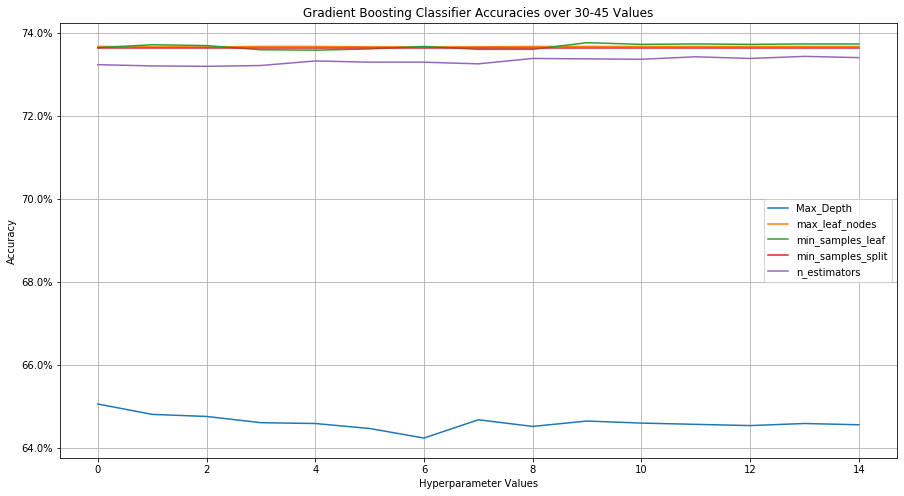

In [27]:
df = df.drop(columns='Counts')
g = df.plot.line(figsize=(15,8),title="Gradient Boosting Classifier Accuracies over 30-45 Values", grid=True);
g.set_xlabel("Hyperparameter Values")
g.set_ylabel("Accuracy")
g.yaxis.set_major_formatter(mtick.PercentFormatter())

Now we will collect the top five of each single hyperparameter and use those as the parameter grid and do a GridSearchCV to determine the best hyperparameters to use in combination. 

In [28]:
maxDepth = df['Max_Depth'].nlargest(5).index.values.tolist()
maxLeafNodes = df['max_leaf_nodes'].nlargest(5).index.values.tolist()
minSamplesLeaf = df['min_samples_leaf'].nlargest(5).index.values.tolist()
minSamplesSplit = df['min_samples_split'].nlargest(5).index.values.tolist()
n_estimators = df['n_estimators'].nlargest(5).index.values.tolist()

#since the index are 0 based, we need to add 1 to get the proper values used
maxDepth = np.array(maxDepth) + 1
maxLeafNodes = np.array(maxLeafNodes) + 1
minSamplesLeaf = np.array(minSamplesLeaf) + 1
minSamplesSplit = np.array(minSamplesSplit) + 1
n_estimators = np.array(n_estimators) + 1

param_grid = {'criterion': ['mse','friedman_mse'],
  'min_samples_split': minSamplesSplit,
  'max_depth': maxDepth,
  'min_samples_leaf': minSamplesLeaf,
  'max_leaf_nodes': maxLeafNodes,
  'n_estimators': n_estimators}
grid = GridSearchCV(gbc, param_grid, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)


print(f"Accuracy: {round(grid.best_score_*100, 2)}%")
for key, value in grid.best_params_.items():
  print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 73.04%
Hyperparameter: criterion; Value: mse
Hyperparameter: max_depth; Value: 8
Hyperparameter: max_leaf_nodes; Value: 10
Hyperparameter: min_samples_leaf; Value: 10
Hyperparameter: min_samples_split; Value: 2
Hyperparameter: n_estimators; Value: 14


Let's save these values as variables so that we can reaccess their information if anything changes as we rerun our code. 

In [29]:
best_gbc = []
for key, value in grid.best_params_.items():
    best_gbc.append(value)

In [30]:
gbc_tuned = GradientBoostingClassifier(random_state=1, criterion=best_gbc[0], min_samples_split=best_gbc[1], 
                                       max_depth=best_gbc[2],
                          min_samples_leaf=best_gbc[3], max_leaf_nodes=best_gbc[4], n_estimators=best_gbc[5])
gbc_tuned.fit(X_train,y_train)
gbc_tuned_pred = gbc_tuned.predict(X_test)
gbc_tuned_acc = round(metrics.accuracy_score(y_test, gbc_tuned_pred)*100, 2)

With our lowered settings, our tuned hyperparameter values turned out to be lower at {{gbc_tuned_acc}}%. We will use the default values for our predictions.

<a id='Predict'></a>
## Predictions

Now we will run our tuned algorithms to predict the classifier. We will do it for each algorithm, combine them into a dataframe and export that dataframe into a csv. 

Let's do some slight data cleaning first by changing the column names again. Then we will modify the categorical into numerical data just like we did for the training data.

In [31]:
test = pd.read_csv('Disease Prediction Testing.csv')

In [32]:
test.rename(columns={'High Blood Pressure':'HighBloodPressure',
                    'Low Blood Pressure':'LowBloodPressure'},
           inplace=True)

In [33]:
#female set to 0 and male set to 1
test = test.replace('female',0)
test = test.replace('male', 1)
#normal 0, high 1, too high 2
test = test.replace('normal',0)
test = test.replace('too high',2)
test = test.replace('high',1)

Now we need to drop the ID columns so that it matches the column length of our previous data. We will move the ID column to our final dataframe. 

In [34]:
final = pd.DataFrame()
final['ID'] = test['ID']
test = test.drop(columns=['ID'])

Now let's run all the predictions on our test dataframe and store the results.

In [35]:
NBCResults = gnbp.predict(test)
KNNResults = neigh_tuned.predict(test)
RanForResults = rfor_tuned.predict(test)
GBMResults = gbc_tuned.predict(test)

Finally, we move the results into our final dataframe and export it to csv for submission. 

In [36]:
final['NBC'] = NBCResults
final['KNN'] = KNNResults
final['RF'] = RanForResults
final['GPM'] = GBMResults

final.to_csv('Prediction_Results.csv', index=False)

<a id='Conclusion'></a>
## Conclusion

While running all of these algorithms, we received the below accuracies with the best parameters that we found for each item. 

| Method | Accuracy | Hyperparameters | 
| --- | --- | --- |
| Guassian Naive Bayes | {{gnb_acc}}% | None |
| K Nearest Neighbor | {{bnb_acc}}% | leaf_size {{best_neigh[0]}}, n_neighbors= {{best_neigh[1]}} |
| Random Forest | {{mnb_acc}}% | criterion={{best_rfor[0]}}, max_depth={{best_rfor[1]}}, max_leaf_nodes={{best_rfor[2]}}, min_samples_leaf={{best_rfor[3]}}, min_samples_split={{best_rfor[4]}}, n_estimators={{best_rfor[5]}} |
| Gradient Boosting | {{gbc_default_acc}}% | Default Values |


Each of these will be used to generate predictions on the dataset to determine whether or not a patient has the disease. 